<a href="https://www.kaggle.com/code/aletbm/mobile-price-classification-with-sklearn-tf?scriptVersionId=116284184" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import libraries
***

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mobile-price-classification/train.csv
/kaggle/input/mobile-price-classification/test.csv


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential

from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px

import random

import keras as K

# Set seed for reproducibility of results
***

In [3]:
seed_value= 111

os.environ['PYTHONHASHSEED']=str(seed_value)

random.seed(seed_value)

np.random.seed(seed_value)

tf.random.set_seed(seed_value)

# About Dataset
***
## Content

In this data:
- id: ID
- battery_power: Total energy a battery can store in one time measured in mAh
- blue: Has bluetooth or not
- clock_speed: speed at which microprocessor executes instructions
- dual_sim: Has dual sim support or not
- fc: Front Camera mega pixels
- four_g: Has 4G or not
- int_memory: Internal Memory in Gigabytes
- m_dep: Mobile Depth in cm
- mobile_wt: Weight of mobile phone
- n_cores: Number of cores of processor
- pc: Primary Camera mega pixels
- px_height: Pixel Resolution Height
- px_width: Pixel Resolution Width
- ram: Random Access Memory in Megabytes
- sc_h: Screen Height of mobile in cm
- sc_w: Screen Width of mobile in cm
- talk_time: Longest time that a single battery charge will last when you are
- three_g: Has 3G or not
- touch_screen: Has touch screen or not
- wifi: Has wifi or not

# Data Upload
***

In [4]:
train = pd.read_csv("../input/mobile-price-classification/train.csv")
test = pd.read_csv("../input/mobile-price-classification/test.csv")

## Let's take a look at the content of our data:

In [5]:
print(f'Cantidad de datos en dataset de entrenamiento: {train.shape[0]}')
print(f'Cantidad de datos en dataset de prueba: {test.shape[0]}')

Cantidad de datos en dataset de entrenamiento: 2000
Cantidad de datos en dataset de prueba: 1000


In [6]:
train.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [7]:
test.head()

,id,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,...,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,1,1043,1,1.8,1,14,0,5,0.1,193,...,16,226,1412,3476,12,7,2,0,1,0
1,2,841,1,0.5,1,4,1,61,0.8,191,...,12,746,857,3895,6,0,7,1,0,0
2,3,1807,1,2.8,0,1,0,27,0.9,186,...,4,1270,1366,2396,17,10,10,0,1,1
3,4,1546,0,0.5,1,18,1,25,0.5,96,...,20,295,1752,3893,10,0,7,1,1,0
4,5,1434,0,1.4,0,11,1,49,0.5,108,...,18,749,810,1773,15,8,7,1,0,1


## Looking for not available values:

In [8]:
train.isna().any()

battery_power    False
blue             False
clock_speed      False
dual_sim         False
fc               False
four_g           False
int_memory       False
m_dep            False
mobile_wt        False
n_cores          False
pc               False
px_height        False
px_width         False
ram              False
sc_h             False
sc_w             False
talk_time        False
three_g          False
touch_screen     False
wifi             False
price_range      False
dtype: bool

In [9]:
test.isna().any()

id               False
battery_power    False
blue             False
clock_speed      False
dual_sim         False
fc               False
four_g           False
int_memory       False
m_dep            False
mobile_wt        False
n_cores          False
pc               False
px_height        False
px_width         False
ram              False
sc_h             False
sc_w             False
talk_time        False
three_g          False
touch_screen     False
wifi             False
dtype: bool

## Looking for null values:

In [10]:
train.isnull().any()

battery_power    False
blue             False
clock_speed      False
dual_sim         False
fc               False
four_g           False
int_memory       False
m_dep            False
mobile_wt        False
n_cores          False
pc               False
px_height        False
px_width         False
ram              False
sc_h             False
sc_w             False
talk_time        False
three_g          False
touch_screen     False
wifi             False
price_range      False
dtype: bool

In [11]:
test.isnull().any()

id               False
battery_power    False
blue             False
clock_speed      False
dual_sim         False
fc               False
four_g           False
int_memory       False
m_dep            False
mobile_wt        False
n_cores          False
pc               False
px_height        False
px_width         False
ram              False
sc_h             False
sc_w             False
talk_time        False
three_g          False
touch_screen     False
wifi             False
dtype: bool

## Data types:

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

# Data visualization:
***

## Is the data balanced?

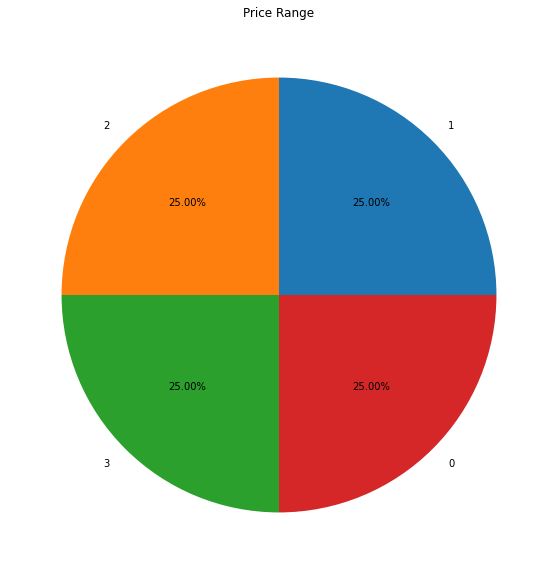

In [13]:
sizes = train["price_range"].value_counts()
plt.figure(figsize=(10,10))
plt.pie(sizes, labels=train["price_range"].unique(), autopct='%1.2f%%')
plt.title("Price Range")
plt.show()

## We create extra features:

In [14]:
train["sc_area"] = train["sc_w"] * train["sc_h"]
train["px_area"] = train["px_width"] * train["px_height"]
train["ram2"] = train["ram"]**2  #we accentuate differences
train["average_mpx"] = (train["fc"] + train["pc"])/2

test["sc_area"] = test["sc_w"] * test["sc_h"]
test["px_area"] = test["px_width"] * test["px_height"]
test["ram2"] = test["ram"]**2  #we accentuate differences
test["average_mpx"] = (test["fc"] + test["pc"])/2

## Features by labels:

<Figure size 576x396 with 0 Axes>

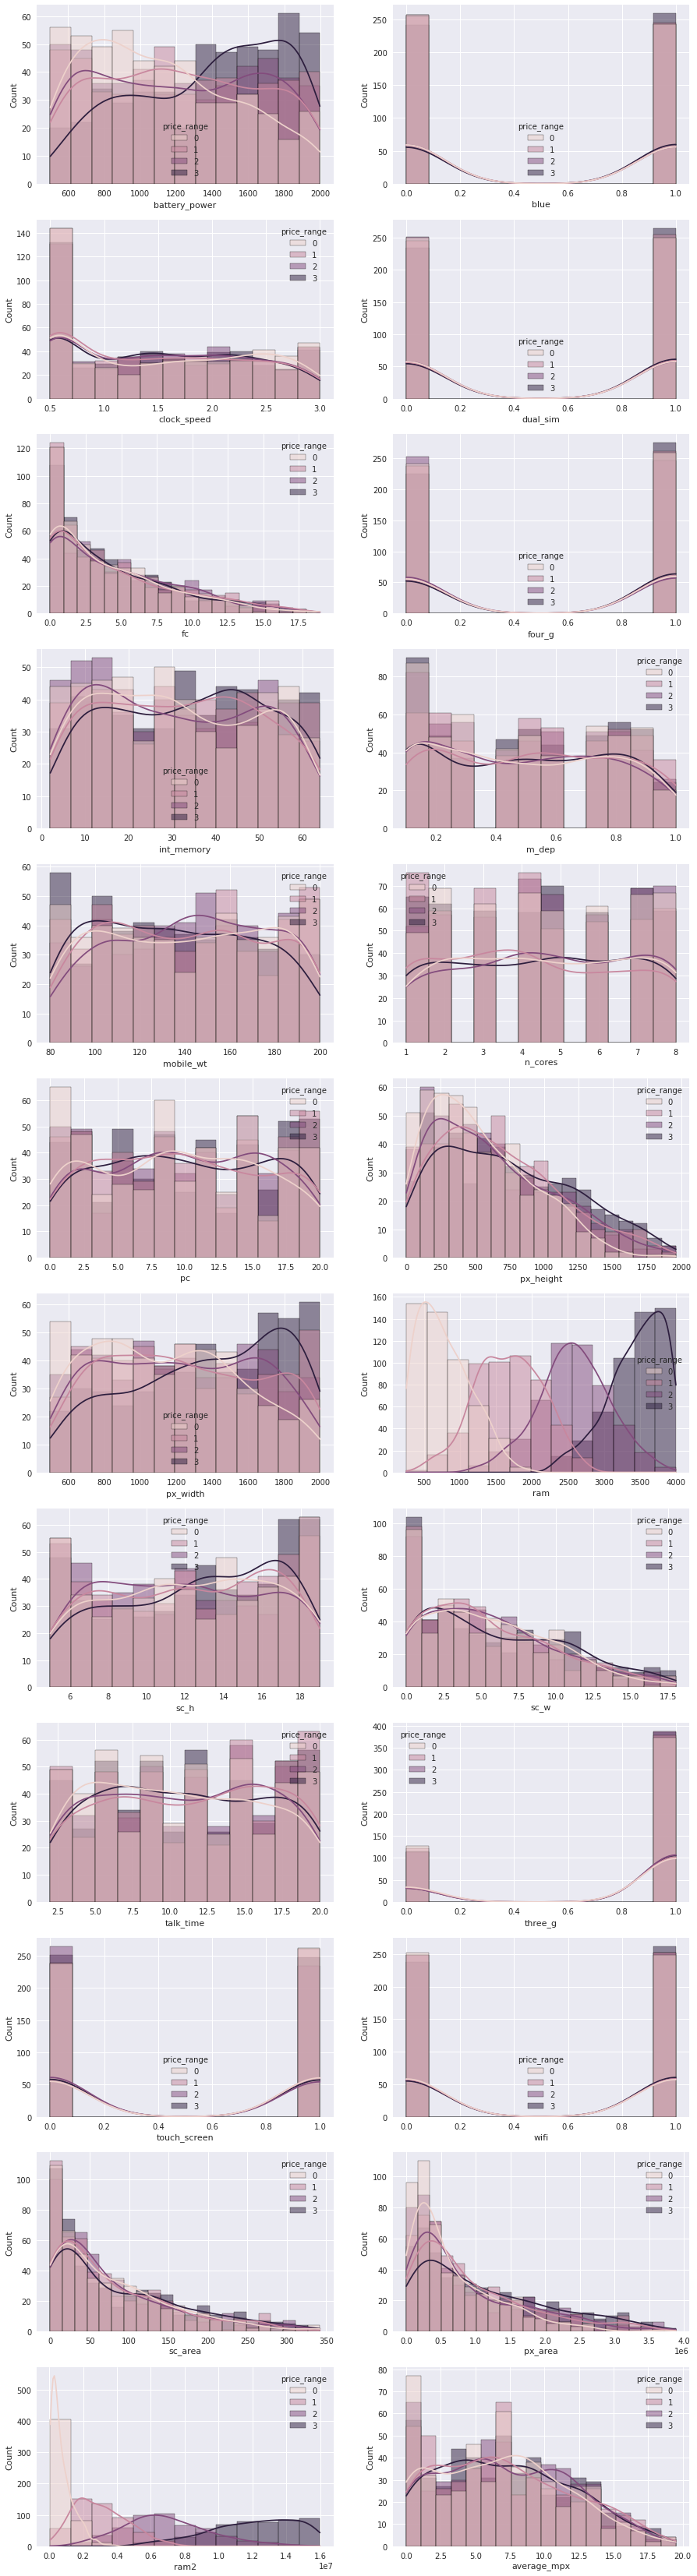

In [15]:
def plot(dataset, f, c, hue, exclude):
    plt.style.use("seaborn")
    sns.set_palette("bright")
    plt.subplots_adjust(hspace=0.2)

    fig,axs = plt.subplots(f,c, figsize = (15,f*5))
    i=1
    for feature in dataset.columns:
        if feature not in exclude:
            plt.subplot(f,c,i)
            sns.histplot(data=dataset, x=feature, kde=True, hue=hue)
            i+=1
            
plot(train, len(train.columns)//2, 2, "price_range", ["price_range"])

## Most important features by label

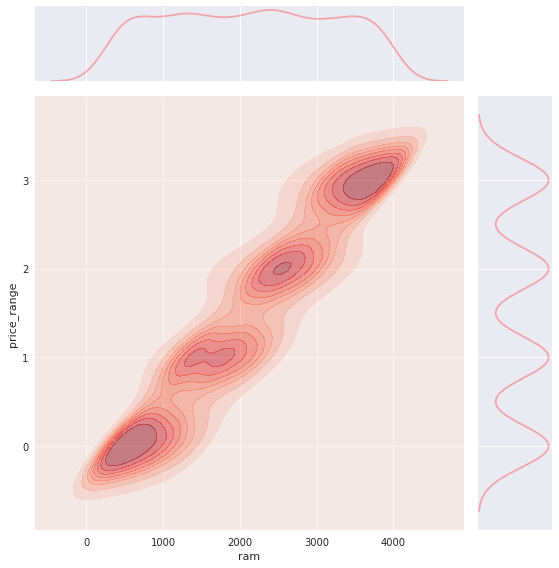

In [16]:
sns.jointplot(x='ram', y='price_range', data=train, cmap="Reds", kind="kde", marginal_kws={"color":"r", "alpha":.3}, shade=True, thresh=0, alpha=0.5, height=8)

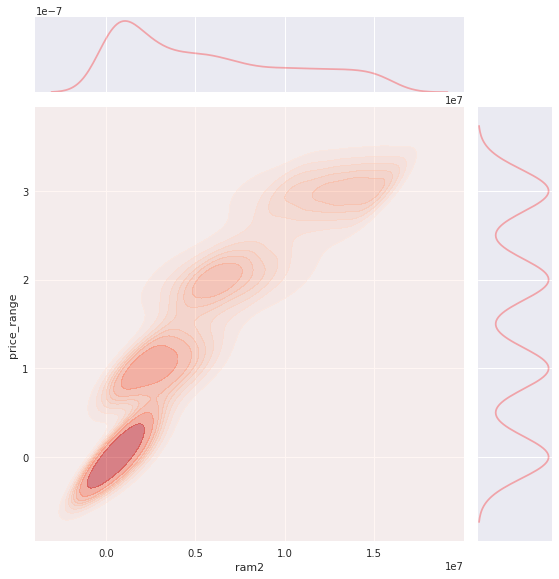

In [17]:
sns.jointplot(x='ram2', y='price_range', data=train, cmap="Reds", kind="kde", marginal_kws={"color":"r", "alpha":.3}, shade=True, thresh=0, alpha=0.5, height=8)

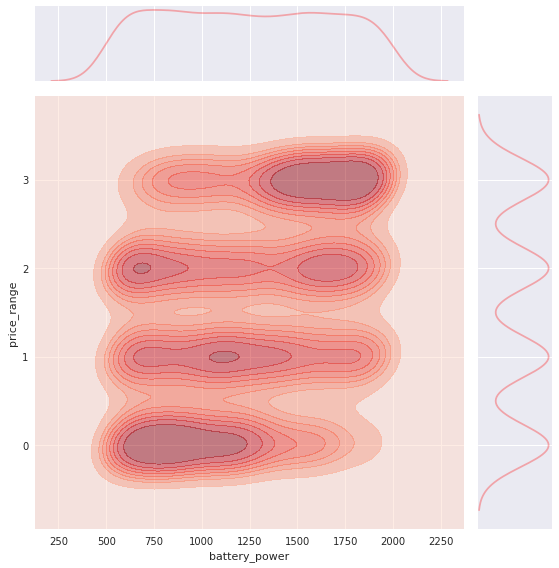

In [18]:
sns.jointplot(x='battery_power', y='price_range', data=train, cmap="Reds", kind="kde", marginal_kws={"color":"r", "alpha":.3}, shade=True, thresh=0, alpha=0.5, height=8)

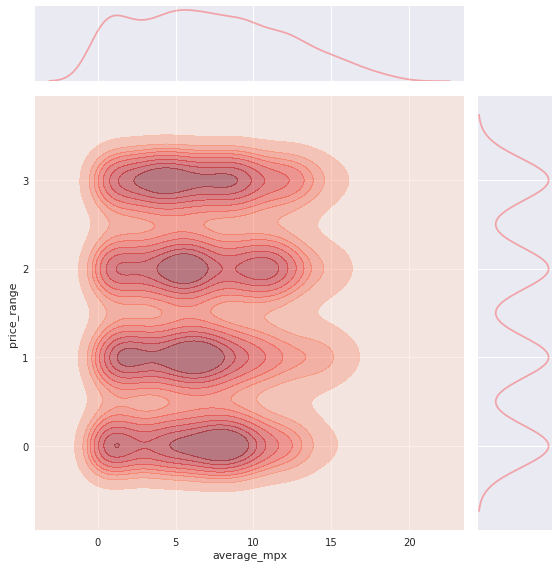

In [19]:
sns.jointplot(x='average_mpx', y='price_range', data=train, cmap="Reds", kind="kde", marginal_kws={"color":"r", "alpha":.3}, shade=True, thresh=0, alpha=0.5, height=8)

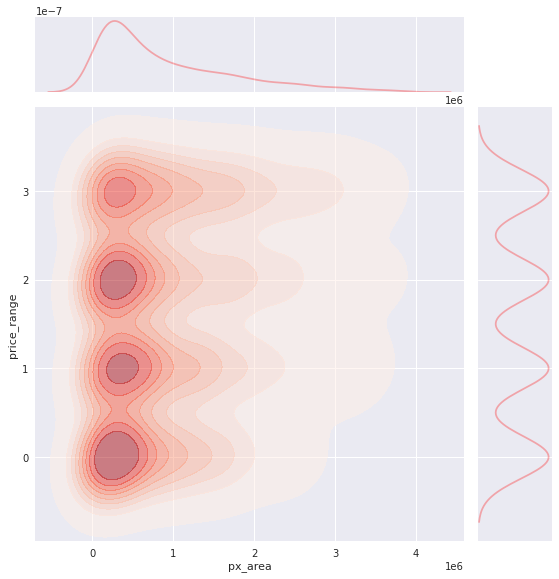

In [20]:
sns.jointplot(x='px_area', y='price_range', data=train, cmap="Reds", kind="kde", marginal_kws={"color":"r", "alpha":.3}, shade=True, thresh=0.01, alpha=0.5, height=8)

## Relations beetwen features by labels:

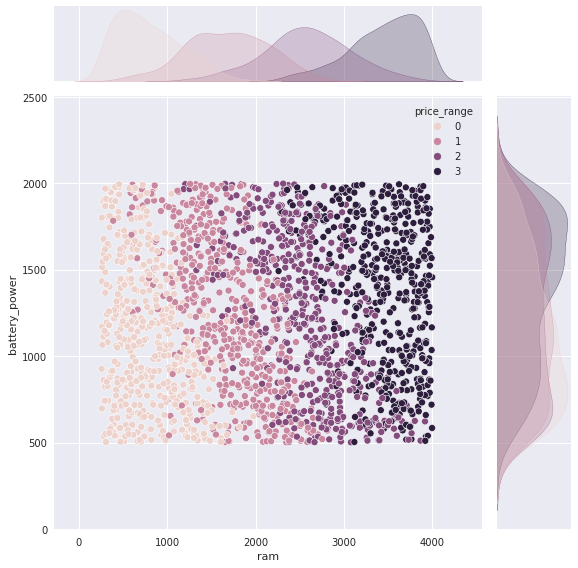

In [21]:
sns.jointplot(x='ram', y='battery_power', hue="price_range", data=train, height=8)

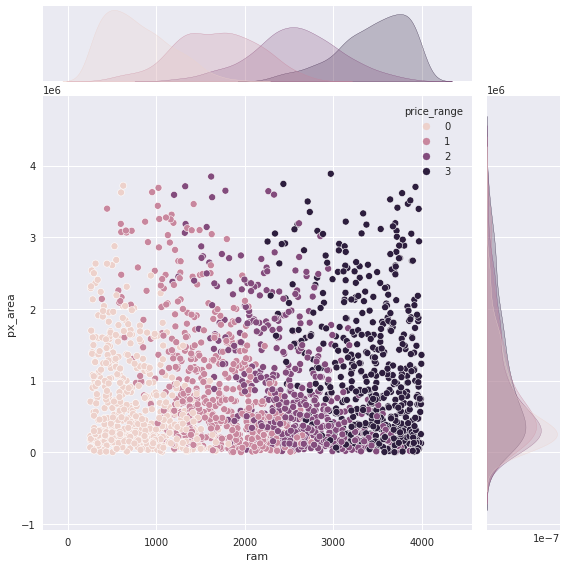

In [22]:
sns.jointplot(x='ram', y='px_area', hue="price_range", data=train, height=8)

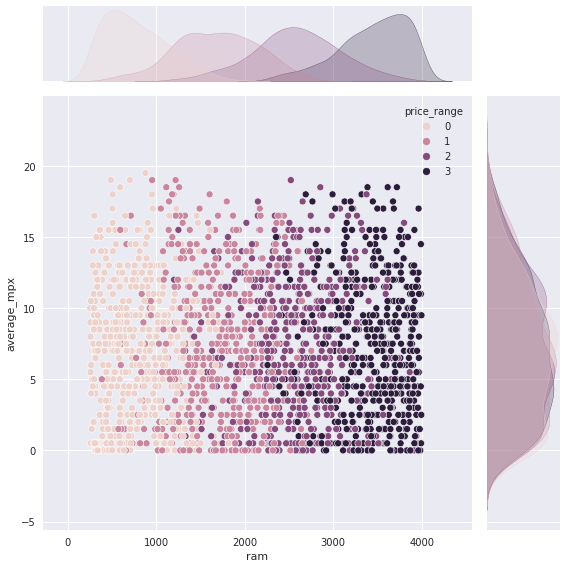

In [23]:
sns.jointplot(x='ram', y='average_mpx', hue="price_range", data=train, height=8)

In [24]:
fig = px.scatter_3d(train, x='ram', y='battery_power', z='px_area', color='price_range')
fig.show()

# Determining the correlations of our data

<AxesSubplot:>

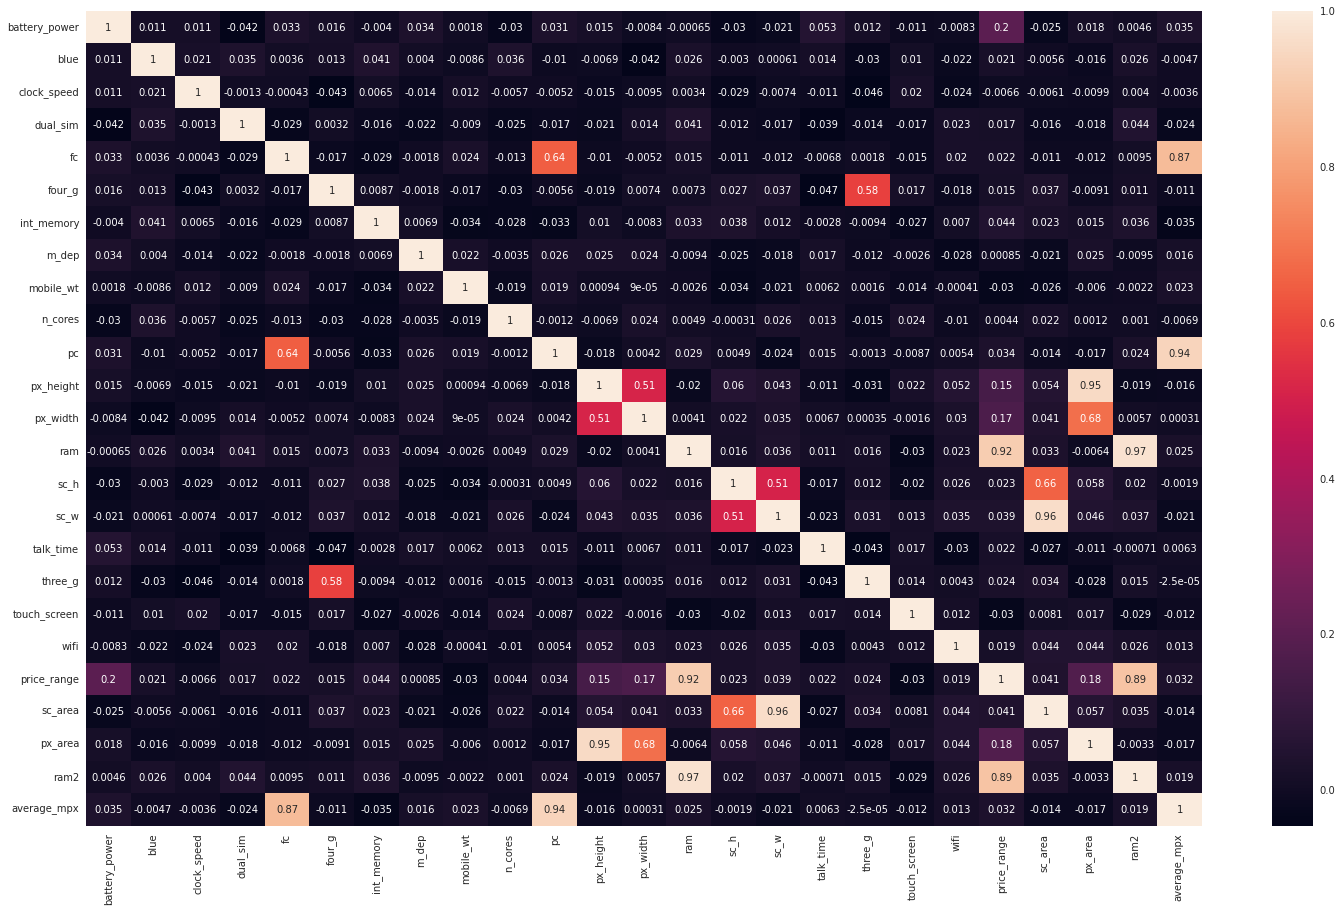

In [25]:
plt.figure(figsize=(25,15))
sns.heatmap(train.corr(), annot=True)

### Determining the correlations between label and features

In [26]:
lista_corr = train.corr()['price_range'].abs().sort_values(ascending=False)[1:]
lista_corr

ram              0.917046
ram2             0.892367
battery_power    0.200723
px_area          0.176240
px_width         0.165818
px_height        0.148858
int_memory       0.044435
sc_area          0.041248
sc_w             0.038711
pc               0.033599
average_mpx      0.031621
touch_screen     0.030411
mobile_wt        0.030302
three_g          0.023611
sc_h             0.022986
fc               0.021998
talk_time        0.021859
blue             0.020573
wifi             0.018785
dual_sim         0.017444
four_g           0.014772
clock_speed      0.006606
n_cores          0.004399
m_dep            0.000853
Name: price_range, dtype: float64

# Dropping features

In [27]:
list_drop = lista_corr[lista_corr < 0.02].keys()
list_drop

Index(['wifi', 'dual_sim', 'four_g', 'clock_speed', 'n_cores', 'm_dep'], dtype='object')

In [28]:
train_clean = train.drop(list_drop, axis=1)
test_clean = test.drop(list_drop, axis=1)
test_clean = test_clean.drop(['id'], axis=1)
id_test = test['id']

# Training set split

In [29]:
X = train_clean.drop("price_range", axis=1)
y = train_clean["price_range"]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.85, random_state=seed_value, shuffle=True, stratify=y)

print(f'Cantidad de datos en dataset de entrenamiento: {X_train.shape[0]}')
print(f'Cantidad de datos en dataset de validacion: {X_valid.shape[0]}')

Cantidad de datos en dataset de entrenamiento: 1700
Cantidad de datos en dataset de validacion: 300


# Normalization

In [30]:
X_train.describe()

,battery_power,blue,fc,int_memory,mobile_wt,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,sc_area,px_area,ram2,average_mpx
count,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1.700000e+03,1.700000e+03,1700.000000
mean,1248.493529,0.490000,4.345294,32.135294,140.480588,9.970000,642.491765,1250.085882,2124.769412,12.295294,5.786471,10.991765,0.761176,0.496471,80.515882,9.018936e+05,5.683126e+06,7.157647
std,442.162395,0.500047,4.351014,18.190039,35.255833,6.099888,446.654412,434.733309,1081.281198,4.201780,4.385586,5.482912,0.426490,0.500135,77.488872,8.366436e+05,4.708692e+06,4.752110
min,501.000000,0.000000,0.000000,2.000000,80.000000,0.000000,0.000000,500.000000,256.000000,5.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000e+00,6.553600e+04,0.000000
25%,856.000000,0.000000,1.000000,16.000000,109.750000,5.000000,278.000000,873.000000,1212.750000,9.000000,2.000000,6.000000,1.000000,0.000000,19.750000,2.589325e+05,1.470763e+06,3.500000
50%,1252.000000,0.000000,3.000000,32.000000,141.000000,10.000000,559.000000,1247.000000,2172.500000,12.000000,5.000000,11.000000,1.000000,0.000000,54.000000,5.882590e+05,4.719756e+06,7.000000
75%,1630.250000,1.000000,7.000000,48.000000,171.000000,15.000000,937.250000,1631.250000,3040.500000,16.000000,9.000000,16.000000,1.000000,1.000000,121.500000,1.362581e+06,9.244659e+06,10.500000
max,1998.000000,1.000000,19.000000,64.000000,200.000000,20.000000,1949.000000,1998.000000,3996.000000,19.000000,18.000000,20.000000,1.000000,1.000000,342.000000,3.886306e+06,1.596802e+07,19.500000


In [31]:
def norm(x):
    return (x - x.describe().transpose()['mean']) / x.describe().transpose()['std']

X_train_norm = norm(X_train)
X_valid_norm = norm(X_valid)

X_test_norm = norm(test_clean)

X_train_norm

,battery_power,blue,fc,int_memory,mobile_wt,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,sc_area,px_area,ram2,average_mpx
1730,0.810803,-0.979908,0.380304,-0.667140,1.461302,-0.322957,0.298907,-0.563761,-1.146574,-0.308273,-1.091410,0.548657,0.559974,1.006788,-0.897108,-0.145837,-1.040608,-0.033174
801,0.392404,-0.979908,2.448787,-1.601717,-0.807826,1.152480,-1.436215,-0.745482,-1.494310,1.595682,-1.091410,-1.457577,0.559974,1.006788,-0.793867,-1.076883,-1.151922,1.860721
1205,-0.351666,-0.979908,-0.539022,-0.557189,1.574758,0.660668,-0.905603,-1.019213,-0.236543,-1.022256,-0.179331,-1.275192,0.559974,1.006788,-0.522861,-0.848423,-0.465090,0.177259
1236,1.233724,1.019904,0.150472,1.256991,-1.545293,-0.486894,-1.342183,-1.433260,-1.593267,0.405710,0.276709,0.548657,0.559974,-0.992674,0.225634,-1.045765,-1.172623,-0.243607
1827,1.003040,-0.979908,-0.079359,-1.656692,-0.978011,1.152480,2.813155,1.504173,1.529880,-0.784262,-0.635370,-0.728037,0.559974,1.006788,-0.690627,3.243678,1.825924,0.703341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1954,-1.272142,1.019904,-0.998685,0.212463,1.518030,-1.470519,-1.295166,-1.161829,-0.575030,-0.546267,-1.319429,0.366272,-1.784746,-0.992674,-1.039064,-1.021001,-0.727191,-1.400988
476,0.767832,-0.979908,-0.998685,1.586841,0.525286,0.496730,0.943701,0.791092,1.060992,1.357688,-1.319429,1.095811,0.559974,1.006788,-1.039064,0.949177,1.066720,-0.138391
622,-0.053133,-0.979908,-0.998685,-1.656692,-0.070360,-1.470519,-0.952620,-0.342936,0.508869,-0.070278,1.188787,0.731041,0.559974,1.006788,0.664407,-0.792424,0.312719,-1.400988
319,-0.342620,-0.979908,0.380304,1.751767,0.582015,-0.322957,-0.500368,1.527176,-0.369718,0.405710,-0.179331,-0.363268,0.559974,-0.992674,-0.135708,-0.119439,-0.575001,-0.033174


In [32]:
X_train_norm.describe()

,battery_power,blue,fc,int_memory,mobile_wt,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,sc_area,px_area,ram2,average_mpx
count,1.700000e+03,1.700000e+03,1.700000e+03,1.700000e+03,1.700000e+03,1.700000e+03,1.700000e+03,1.700000e+03,1.700000e+03,1.700000e+03,1.700000e+03,1.700000e+03,1.700000e+03,1.700000e+03,1.700000e+03,1.700000e+03,1.700000e+03,1.700000e+03
mean,-1.149407e-17,3.343731e-17,-7.523394e-17,1.253899e-16,2.883968e-16,-9.926700e-17,-1.776357e-17,1.880848e-16,-1.964442e-16,1.055365e-16,5.224579e-17,-6.060512e-17,-1.734560e-16,-6.269495e-17,1.462882e-17,-1.671865e-17,1.044916e-16,9.299751e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.690541e+00,-9.799077e-01,-9.986855e-01,-1.656692e+00,-1.715478e+00,-1.634456e+00,-1.438454e+00,-1.725393e+00,-1.728292e+00,-1.736239e+00,-1.319429e+00,-1.639962e+00,-1.784746e+00,-9.926738e-01,-1.039064e+00,-1.077990e+00,-1.193026e+00,-1.506204e+00
25%,-8.876683e-01,-9.799077e-01,-7.688540e-01,-8.870401e-01,-8.716455e-01,-8.147690e-01,-8.160487e-01,-8.673959e-01,-8.434618e-01,-7.842615e-01,-8.633899e-01,-9.104222e-01,5.599743e-01,-9.926738e-01,-7.841885e-01,-7.685006e-01,-8.945932e-01,-7.696891e-01
50%,7.930278e-03,-9.799077e-01,-3.091910e-01,-7.437814e-03,1.473265e-02,4.918123e-03,-1.869270e-01,-7.098334e-03,4.414262e-02,-7.027835e-02,-1.793308e-01,1.501993e-03,5.599743e-01,-9.926738e-01,-3.421895e-01,-3.748724e-01,-2.045939e-01,-3.317412e-02
75%,8.633852e-01,1.019904e+00,6.101350e-01,8.721645e-01,8.656557e-01,8.246053e-01,6.599246e-01,8.767769e-01,8.468940e-01,8.816993e-01,7.327480e-01,9.134262e-01,5.599743e-01,1.006788e+00,5.289033e-01,5.506377e-01,7.563741e-01,7.033408e-01
max,1.695093e+00,1.019904e+00,3.368113e+00,1.751767e+00,1.688215e+00,1.644292e+00,2.925099e+00,1.720398e+00,1.730568e+00,1.595682e+00,2.784925e+00,1.642966e+00,5.599743e-01,1.006788e+00,3.374473e+00,3.567125e+00,2.184235e+00,2.597236e+00


# Building and training models

## Classifiers implemented with ScitKit-Learn

### Logistic Regression Classifier

In [33]:
log_r = LogisticRegression(max_iter=10000, random_state=seed_value)
log_r.fit(X_train_norm, y_train)
print('Accuracy:', log_r.score(X_valid_norm, y_valid))

Accuracy: 0.98


### Random Forest Classifier and Grid Search for model tuning

In [34]:
rf_r = RandomForestClassifier(random_state=seed_value, bootstrap = True)
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

param_grid = {"n_estimators": n_estimators,
             "max_depth": max_depth}

grid = GridSearchCV(rf_r, param_grid, cv = 3, n_jobs = -1)
grid.fit(X_train_norm, y_train)
grid.best_params_

{'max_depth': 10, 'n_estimators': 200}

In [35]:
best_grid = grid.best_estimator_
print('Accuracy:', best_grid.score(X_valid_norm, y_valid))

Accuracy: 0.9466666666666667


##  Classifiers implemented with Tensorflow

### Learning rate tuning

In [36]:
reg= 0.0001
model = Sequential([
    Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg), input_shape=[len(X_train.columns)]),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg)),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg)),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg)),
    Dense(4, activation='softmax')
])

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            optimizer='adam',
            metrics=['accuracy'])

model.summary()

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                608       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1

2023-01-13 17:43:50.282794: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [37]:
history = model.fit(x=X_train_norm,
                    y=y_train,
                    epochs=100,
                    validation_data=(X_valid_norm, y_valid),
                    batch_size=32,
                    callbacks=[lr_scheduler]
                    )

2023-01-13 17:43:50.645398: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
54/54 [==============================] - 2s 10ms/step - loss: 1.5485 - accuracy: 0.2388 - val_loss: 1.4123 - val_accuracy: 0.2167
Epoch 2/100
54/54 [==============================] - 0s 4ms/step - loss: 1.5149 - accuracy: 0.2559 - val_loss: 1.4053 - val_accuracy: 0.2233
Epoch 3/100
54/54 [==============================] - 0s 4ms/step - loss: 1.4930 - accuracy: 0.2588 - val_loss: 1.3987 - val_accuracy: 0.2333
Epoch 4/100
54/54 [==============================] - 0s 4ms/step - loss: 1.4844 - accuracy: 0.2376 - val_loss: 1.3925 - val_accuracy: 0.2533
Epoch 5/100
54/54 [==============================] - 0s 4ms/step - loss: 1.4540 - accuracy: 0.2718 - val_loss: 1.3867 - val_accuracy: 0.2567
Epoch 6/100
54/54 [==============================] - 0s 4ms/step - loss: 1.4456 - accuracy: 0.2635 - val_loss: 1.3818 - val_accuracy: 0.2767
Epoch 7/100
54/54 [==============================] - 0s 4ms/step - loss: 1.4217 - accuracy: 0.2718 - val_loss: 1.3745 - val_accuracy: 0.3167
Epoch 8/100


Text(0, 0.5, 'Loss')

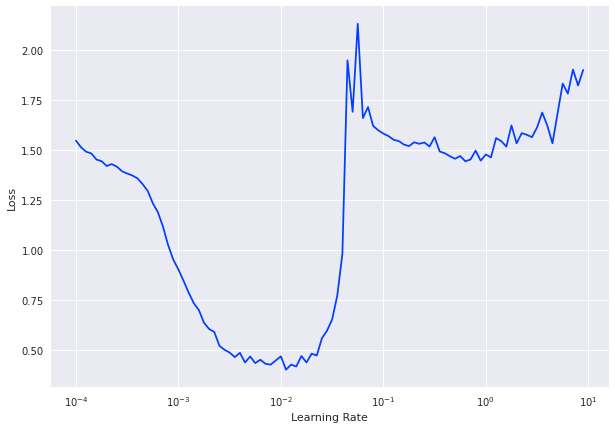

In [38]:
lrs = 1e-4 * (10 ** (np.arange(100)/20))
plt.figure(figsize=(10,7))
plt.semilogx(lrs, history.history['loss'])
plt.xlabel('Learning Rate')
plt.ylabel('Loss')

In [39]:
minimum = min(history.history['loss'])
index = history.history['loss'].index(minimum)
lr = lrs[index]
lr

0.01122018454301963

### Training with learning rate tuning

In [40]:
neurons = 130
reg= 0.0001

model = Sequential([
    Dense(neurons, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg), input_shape=[len(X_train.columns)]),
    Dropout(0.5),
    Dense(neurons, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg)),
    Dropout(0.5),
    Dense(neurons, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg)),
    Dropout(0.5),
    Dense(neurons, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg)),
    Dense(4, activation='softmax')
])

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
            metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 130)               2470      
_________________________________________________________________
dropout_3 (Dropout)          (None, 130)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 130)               17030     
_________________________________________________________________
dropout_4 (Dropout)          (None, 130)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 130)               17030     
_________________________________________________________________
dropout_5 (Dropout)          (None, 130)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 130)              

In [41]:
epochs=1250
history = model.fit(x=X_train_norm,
                    y=y_train,
                    epochs=epochs,
                    validation_data=(X_valid_norm, y_valid),
                    batch_size=128
                    )

Epoch 1/1250
14/14 [==============================] - 1s 27ms/step - loss: 1.0709 - accuracy: 0.5218 - val_loss: 0.5365 - val_accuracy: 0.8967
Epoch 2/1250
14/14 [==============================] - 0s 10ms/step - loss: 0.7174 - accuracy: 0.6959 - val_loss: 0.5276 - val_accuracy: 0.8200
Epoch 3/1250
14/14 [==============================] - 0s 10ms/step - loss: 0.6238 - accuracy: 0.7447 - val_loss: 0.4560 - val_accuracy: 0.8700
Epoch 4/1250
14/14 [==============================] - 0s 9ms/step - loss: 0.5377 - accuracy: 0.7959 - val_loss: 0.3811 - val_accuracy: 0.8800
Epoch 5/1250
14/14 [==============================] - 0s 9ms/step - loss: 0.4702 - accuracy: 0.8288 - val_loss: 0.3286 - val_accuracy: 0.9200
Epoch 6/1250
14/14 [==============================] - 0s 9ms/step - loss: 0.4471 - accuracy: 0.8329 - val_loss: 0.3218 - val_accuracy: 0.8833
Epoch 7/1250
14/14 [==============================] - 0s 9ms/step - loss: 0.4620 - accuracy: 0.8335 - val_loss: 0.3360 - val_accuracy: 0.9067
Epo

### Accuracy and loss in training and validation set

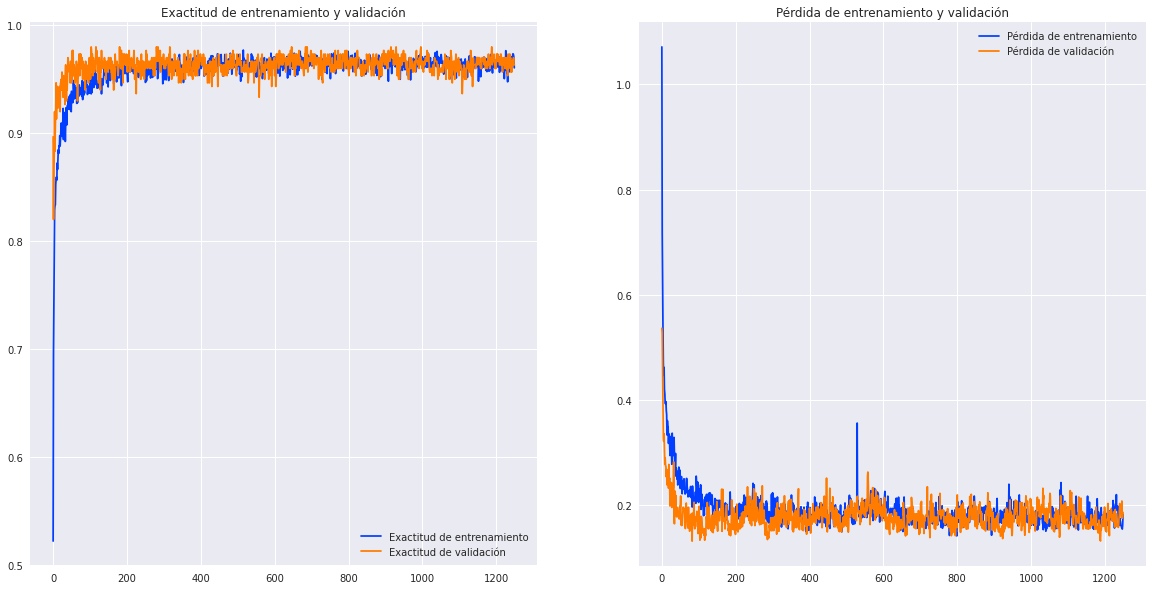

In [42]:
def plot_model_history(model_history, epochs):

    acc = model_history.history['accuracy']
    val_acc = model_history.history['val_accuracy']

    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Exactitud de entrenamiento')
    plt.plot(epochs_range, val_acc, label='Exactitud de validación')
    plt.legend(loc='lower right')
    plt.title('Exactitud de entrenamiento y validación')

    plt.subplot(122)
    plt.plot(epochs_range, loss, label='Pérdida de entrenamiento')
    plt.plot(epochs_range, val_loss, label='Pérdida de validación')
    plt.legend(loc='upper right')
    plt.title('Pérdida de entrenamiento y validación')

    plt.show()
    
plot_model_history(history, epochs)

### Evaluated model with validation set

In [43]:
model.evaluate(X_valid_norm, y_valid)

10/10 [==============================] - 0s 3ms/step - loss: 0.1867 - accuracy: 0.9633


[0.1867060363292694, 0.9633333086967468]

### Save model

In [44]:
model.save("tfModel.h5")
model.save_weights('tf_Model_weight')

### Confusion Matrix

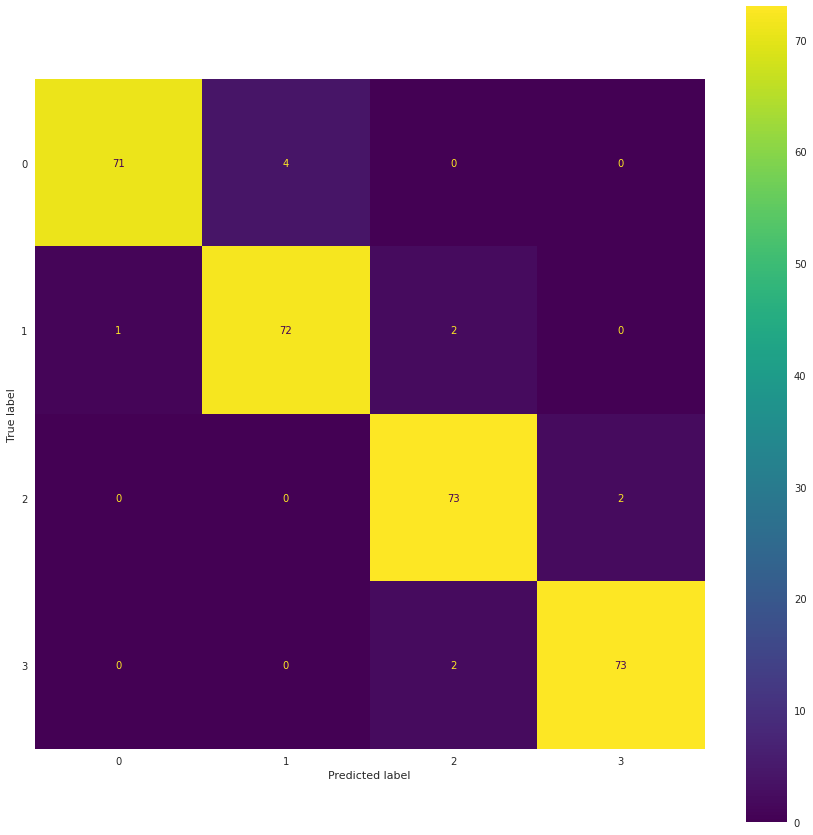

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def get_price_range(row):
    for c in [0,1,2,3]:
        if row[c]==1:
            return c

y_valid_pred = tf.round(model.predict(X_valid_norm))
valid_labels = pd.DataFrame(data={0:y_valid_pred[:,0], 1:y_valid_pred[:,1], 2:y_valid_pred[:,2], 3:y_valid_pred[:,3]})
valid_pred = valid_labels.apply(get_price_range, axis=1, )
y_valid_pred = pd.DataFrame(data={'price_range':valid_pred})

cm = confusion_matrix(y_valid, y_valid_pred)

disp = ConfusionMatrixDisplay(cm)

fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax)
plt.grid(visible=False)

### Predictions of our model

In [46]:
y_test_pred = tf.round(model.predict(X_test_norm))
y_test_pred

<tf.Tensor: shape=(1000, 4), dtype=float32, numpy=
array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)>

In [47]:
test_labels = pd.DataFrame(data={0:y_test_pred[:,0], 1:y_test_pred[:,1], 2:y_test_pred[:,2], 3:y_test_pred[:,3]})
test_labels

,0,1,2,3
0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0
...,...,...,...,...
995,0.0,0.0,1.0,0.0
996,0.0,1.0,0.0,0.0
997,1.0,0.0,0.0,0.0
998,0.0,0.0,1.0,0.0


In [48]:
labels_pred = test_labels.apply(get_price_range, axis=1, )
labels = pd.DataFrame(data={'id':id_test, 'price_range':labels_pred})
labels

,id,price_range
0,1,3
1,2,3
2,3,2
3,4,3
4,5,1
...,...,...
995,996,2
996,997,1
997,998,0
998,999,2


### Save predictions

In [49]:
labels.to_csv('/kaggle/working/test_labels.csv', index=False)